# Dimension Reduction or Concept Learning?

It is a common preprocessing step in machine learning goals (eg classification, regression, clustering, etc.) to reduce the dimensionality of the data. Having high dimensionality could lead to different problems for different machine learning tasks. For example, in clustering, high dimensionality might lead to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). There is a multitude of approaches for reducing the dimensions of a dataset; these techniques often project the data in the original high-dimensional space to a new lower-dimensional space. The key word here is `space`; the original high-dimensional space is the raw space where the data exists; the new low-dimensional space is a new space which the data is being projected into. 

But what's the meaning of the new space? The new lower-dimensional space can be interpreted in many different but related ways. One interpretation is that although the new space has a lower number of dimensions, this new space organizes the original dimensions into higher-order meaning. That's the confusion; the new lower-dimesional space represents higher order meaning. This new space is also called the `hidden space` or `latent` space. When dimesion reduction techniques are used, it is better to understand them as a reprojection of the data into a space of higher order meaning, although the new space will have a smaller number of dimensions. These new dimensions are often called `components` when using techniques like principal component analysis `PCA`. 

Here's a motivating example. Imagine we have news articles with a lot of words. The representation of these documents could be a [vector space model](https://en.wikipedia.org/wiki/Vector_space_model) `VSM` where the documents correspond to rows and words correspond to columns. Each element in the VSM could simply be the count of number of times a word appears in a document. We can project this VSM into a new space where the axes (columns/fields) are higher-order meaning or concepts. For example, the words could be reprojected to their types (eg adjective, verbs, nouns, etc). 

In the example below, we will play around with the [breast cancer data from Scikit-Learn](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset) and apply a few different "dimension reduction" techniques. Let's see if these techniques can recover any concepts or higher-order meaning from the raw features.

## Breast cancer data

There's nothing important here; we simply load the data. Note that this dataset is intended for a classification problem. Interesting, 0 denotes malignant and 1 denotes benign. There's 30 features in this dataset.

In [1]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y_map = {0: 'malignant', 1: 'benign'}

X.shape, y.shape

((569, 30), (569,))

In [2]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
y.value_counts().sort_index()

target
0    212
1    357
Name: count, dtype: int64

## Decomposition

We will use 4 different dimension reduction algorithms.

- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) denoted as `pca`
- [kernel PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis) denoted as `kpca`
- [factor analysis](https://en.wikipedia.org/wiki/Factor_analysis) denoted as `fa`
- [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) denoted as `tsne`

In the code below,

- `M` stores the models, and
- `D` stores the projected data corresponding to the models.

Note that the number of components is hard-coded to `2` for illustration purposes. Ideally, we would want to tune this hyperparameter.

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis
from sklearn.manifold import TSNE

M = {
    'pca': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', PCA(n_components=2, random_state=37))
    ]),
    'kpca': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', KernelPCA(n_components=2, kernel='rbf', random_state=37))
    ]),
    'fa': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', FactorAnalysis(n_components=2, random_state=37))
    ]),
    'tsne': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', TSNE(n_components=2, n_jobs=-1, random_state=37))
    ])
}

to_df = lambda mat: pd.DataFrame(mat, columns=[f'C{i}' for i in range(mat.shape[1])])
D = {k: to_df(m.fit_transform(X)) for k, m in M.items()}

## Density plots

Here are the density plots for the first `C0` and second `C1` components for each technique.

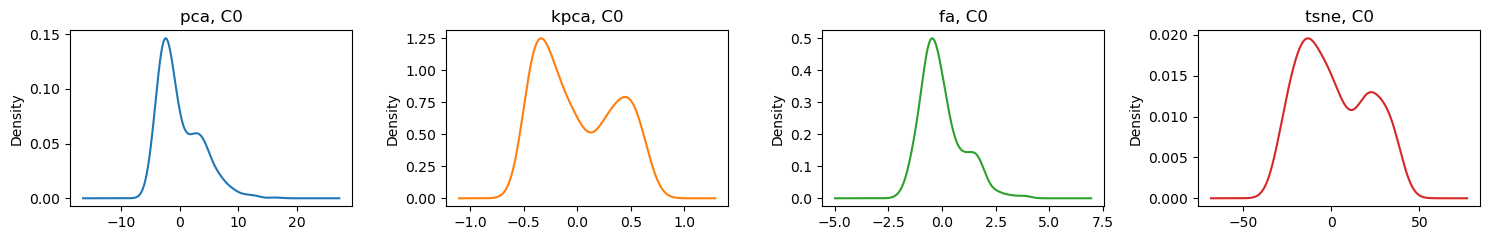

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(15, 2.5))

for algo, ax, color in zip(D, np.ravel(axes), sns.color_palette('tab10')):
    D[algo]['C0'].plot(kind='kde', ax=ax, title=f'{algo}, C0', color=color)
    
fig.tight_layout()

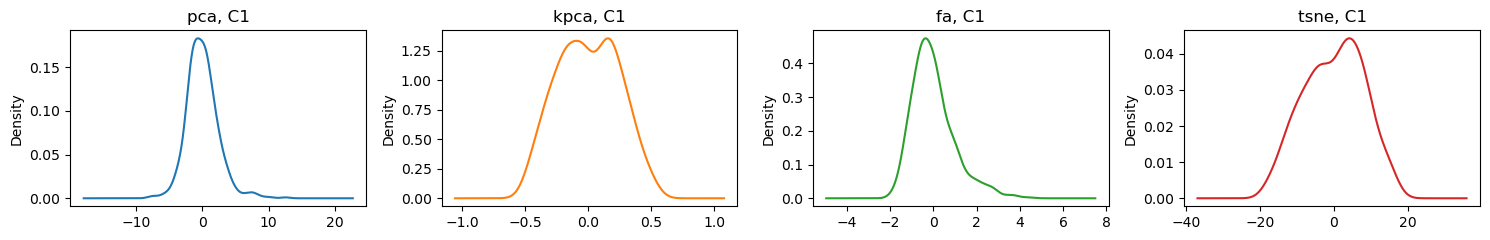

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(15, 2.5))

for algo, ax, color in zip(D, np.ravel(axes), sns.color_palette('tab10')):
    D[algo]['C1'].plot(kind='kde', ax=ax, title=f'{algo}, C1', color=color)
    
fig.tight_layout()

Here are some bivariate density plots for the two components learned by each of the algorithms. PCA and kernel PCA seem to have 2 centers; factor analysis has one and tSNE seem to have 4.

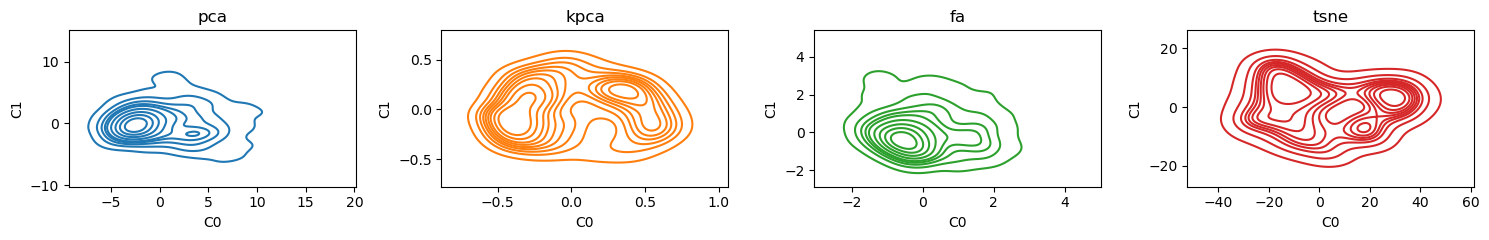

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 2.5))

for algo, ax, color in zip(D, np.ravel(axes), sns.color_palette('tab10')):
    sns.kdeplot(data=D[algo], x='C0', y='C1', ax=ax, color=color)
    ax.set_title(algo)
    
fig.tight_layout()

## Scatter plots

Take a look at the reprojected data color-coded by class (malignant vs benign). Interestingly, going from 30 dimensions to 2, there seems to be linear separability for all techniques!

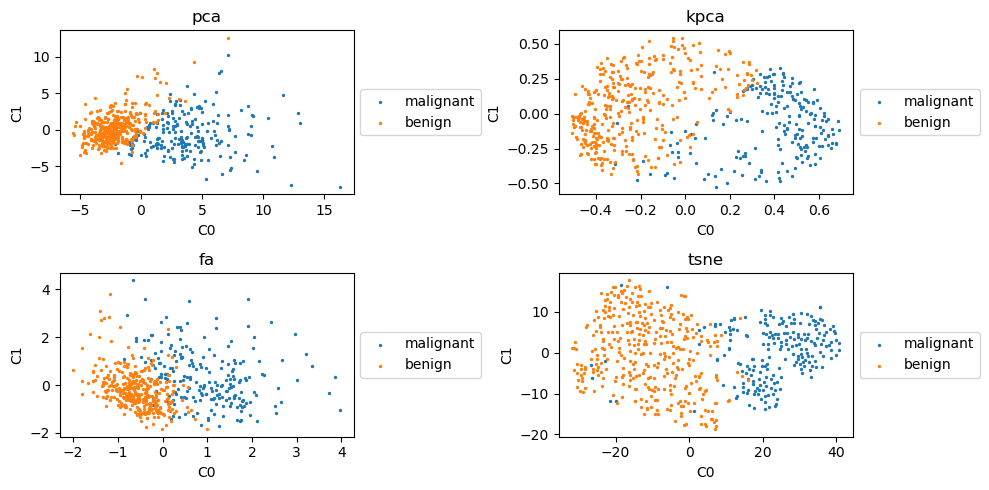

In [8]:
import seaborn as sns

def scatter_plot(d, k, ax):
    df = d.assign(y=y)
    
    for y_val, color in zip(y.unique(), sns.color_palette('tab10')):
        label = y_map[y_val]
        df[df['y']==y_val].plot(
            kind='scatter', 
            x='C0', 
            y='C1', 
            ax=ax, 
            color=color, 
            label=label,
            s=2
        )
        
    ax.set_title(k)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for k, ax in zip(D.keys(), np.ravel(axes)):
    scatter_plot(D[k], k, ax)

fig.tight_layout()

## Classification

If the new dimensions are meaningful, they should help with classification. Below are the non-validated classification performances of each technique. Evidently, PCA and tSNE have the best performances in terms of area under the ROC curve and average precision score.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

def get_performance(Z, algo):
    m = LogisticRegression(random_state=37, n_jobs=-1, solver='saga', max_iter=10_000)
    m.fit(Z, y)
    y_pred = m.predict(Z)

    roc, aps = roc_auc_score(y, y_pred), average_precision_score(y, y_pred)
    return {
        'algo': algo,
        'roc': roc,
        'aps': aps
    }

pd.DataFrame([get_performance(D[algo], algo) for algo in D.keys()])

,algo,roc,aps
0,pca,0.950617,0.949288
1,kpca,0.922903,0.923345
2,fa,0.910153,0.909794
3,tsne,0.954376,0.952908


Here's the kicker, learning a logistic regression classification model from the raw dimensions performs worse than learning one using the new and fewer dimensions.

In [10]:
m = LogisticRegression(random_state=37, n_jobs=-1, solver='saga', max_iter=10_000)
m.fit(X, y)
y_pred = m.predict(X)

roc_auc_score(y, y_pred), average_precision_score(y, y_pred)

(0.9086795095396649, 0.9067761384577263)

## Coefficients

If we wanted to know how the old dimensions influences the new ones, we can perform regression. Since there are 2 components, we will compute 2 regressions of the component on the old dimensions for each algorithm. Below, after we get the regression coefficients, we rescale them to the range [20, 100] to make side-by-side comparison of the coefficients easier.

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def get_components(algo, regressor='rf'):
    def get_regressor():
        regressors = {
            'linear': lambda: LinearRegression(fit_intercept=False, n_jobs=-1),
            'ridge': lambda: Ridge(fit_intercept=False, random_state=37),
            'lasso': lambda: Lasso(fit_intercept=False, random_state=37),
            'en': lambda: ElasticNet(l1_ratio=0.5, fit_intercept=False, random_state=37),
            'rf': lambda: RandomForestRegressor(random_state=37, n_jobs=-1)
        }
        
        if regressor in regressors:
            return regressors[regressor]
        return regressors['linear']
    
    def get_influence(c):
        r = get_regressor()()
        q = pd.DataFrame(StandardScaler().fit_transform(D[algo]), columns=D[algo].columns)
        q = q[c]
        
        r.fit(Z, q)
        
        if regressor == 'rf':
            f = r.feature_importances_
        else:
            f = r.coef_
            
        return pd.Series(np.abs(f), index=X.columns)

    Z = M[algo].named_steps['scaler'].transform(X)

    return pd.DataFrame({
            f'{algo}_C0': get_influence('C0'),
            f'{algo}_C1': get_influence('C1')
        })

def rescale(X):
    S = MinMaxScaler((20, 100)).fit_transform(X)
    
    S = pd.DataFrame(S, columns=X.columns, index=X.index) \
        .assign(**{
            f'__{X.columns[0]}': S[:,0]
        })

    return S

I = get_components('pca') \
    .join(get_components('kpca')) \
    .join(get_components('fa')) \
    .join(get_components('tsne')).T

I = rescale(I)
I

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,__mean radius
pca_C0,20.000000,27.660293,21.012388,20.089757,24.708053,25.028562,64.230320,100.000000,23.131311,20.070961,...,25.415234,31.177773,23.188636,23.694922,57.657200,40.778190,38.716474,25.768649,20.242635,20.000000
pca_C1,22.456687,25.707383,20.694835,57.455354,35.779462,21.683326,20.272224,20.750085,38.187873,100.000000,...,26.703584,33.359398,62.578362,51.705521,37.667882,38.185203,20.203508,33.673474,20.712339,22.456687
kpca_C0,20.124217,60.862211,20.000000,20.338962,34.834190,25.588299,100.000000,24.587450,27.726151,21.120664,...,31.514524,59.600710,35.243865,40.871446,57.364089,31.329845,21.401781,27.499165,20.917665,20.124217
kpca_C1,29.785557,37.624838,22.388116,93.877927,56.684593,22.079040,21.095430,20.598039,35.412102,74.147545,...,31.779264,65.516090,100.000000,47.628771,51.862636,34.163889,20.482895,34.958548,20.524924,29.785557
fa_C0,100.000000,20.000000,100.000000,100.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,100.000000
fa_C1,20.485784,29.111360,20.073381,22.051355,75.004853,100.000000,21.330962,20.438261,57.870181,49.368413,...,24.869753,20.951976,21.719272,65.038759,83.453114,100.000000,20.252925,33.431891,100.000000,20.485784
tsne_C0,20.133475,69.253239,20.226565,20.000000,52.425656,41.197356,29.660382,60.896868,24.332261,20.166627,...,80.989377,100.000000,40.055801,100.000000,100.000000,34.865060,100.000000,27.238558,20.766349,20.133475
tsne_C1,22.389117,100.000000,21.237619,41.932225,100.000000,30.457442,20.524996,21.595629,100.000000,44.820743,...,100.000000,43.921935,40.136060,89.301745,83.488993,67.899110,21.297724,100.000000,23.009203,22.389117


In the table above, you can understand it by going down each colum or row. Going down each column, the value indicates the strength of influence of the original dimension on the new one. Going across each row, the value indicates how each column influences the component in magnitude (note that direction was removed by taking the absolute value of all coefficients).

For PCA, this regression of the new dimension on the old ones produces the eigenvectors!

## Parallel coordinates

Now, we make the desperate attempt to visualize to see if there is any sensible higher-order meaning in the components. There's a lot to look at, but for tSNE it seems the first component is about the "worst" features.

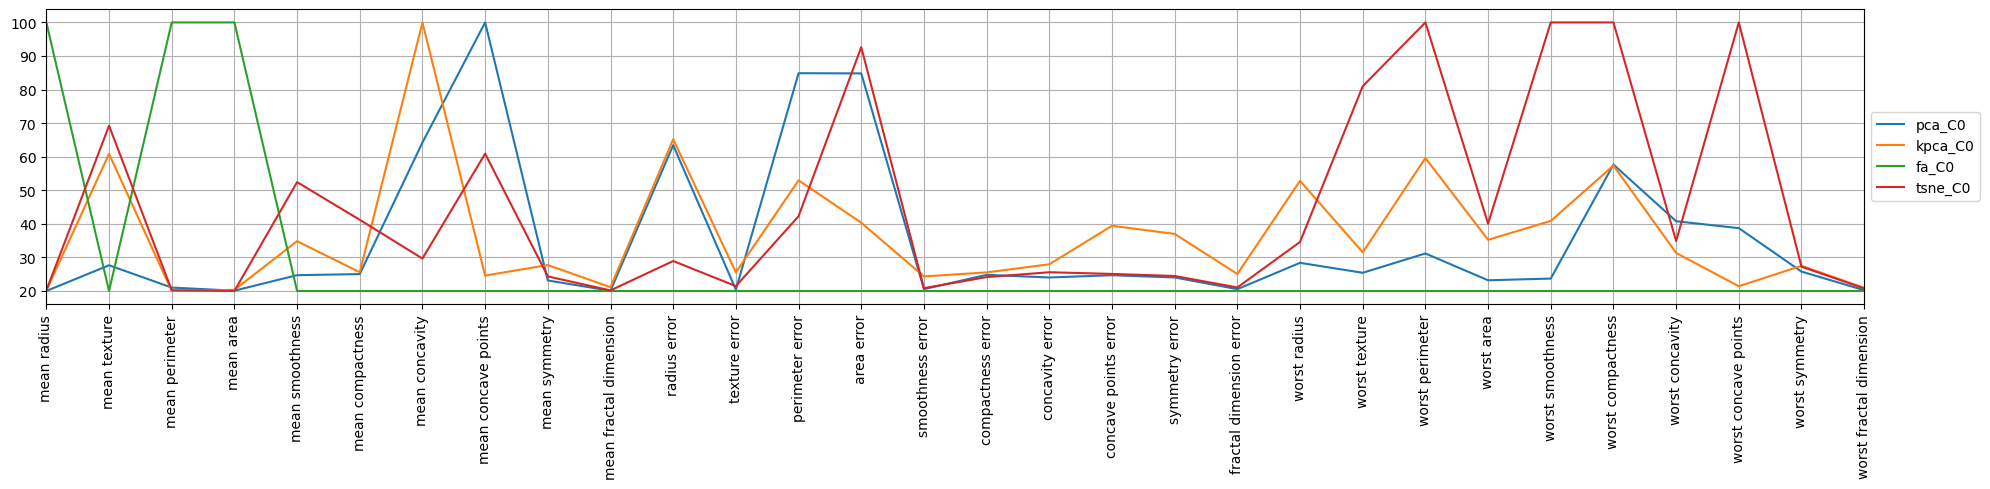

In [12]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)

pd.plotting.parallel_coordinates(
    I.assign(y=I.index)[[True if i.endswith('C0') else False for i in I.index]] \
        .drop(columns=['__mean radius']), 
    'y', 
    color=sns.color_palette('tab10'), 
    sort_labels=False, 
    axvlines=False,
    ax=ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

When looking at the second component for tSNE, it seems this component is about the "error" features.

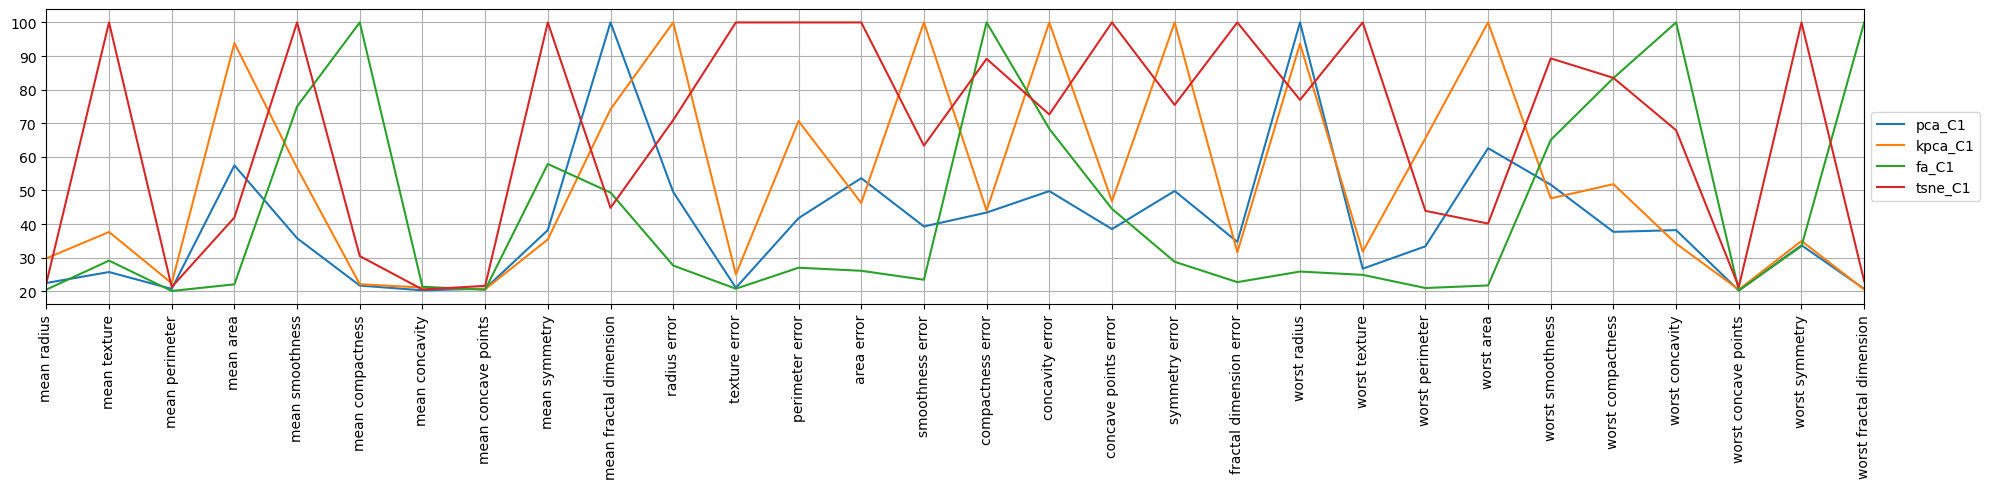

In [13]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)

pd.plotting.parallel_coordinates(
    I.assign(y=I.index)[[True if i.endswith('C1') else False for i in I.index]] \
        .drop(columns=['__mean radius']), 
    'y', 
    color=sns.color_palette('tab10'), 
    sort_labels=False, 
    axvlines=False,
    ax=ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

## Radial plots

Perhaps radial plots can also give us a better intuition into what the concepts or higher-order meaning of the components are. The radial plot for tSNE gravitates towards the "worst" features, which confirms the interpretation from the parallel coordinate plot. Interestingly, for PCA, the first component is about the "mean" features.

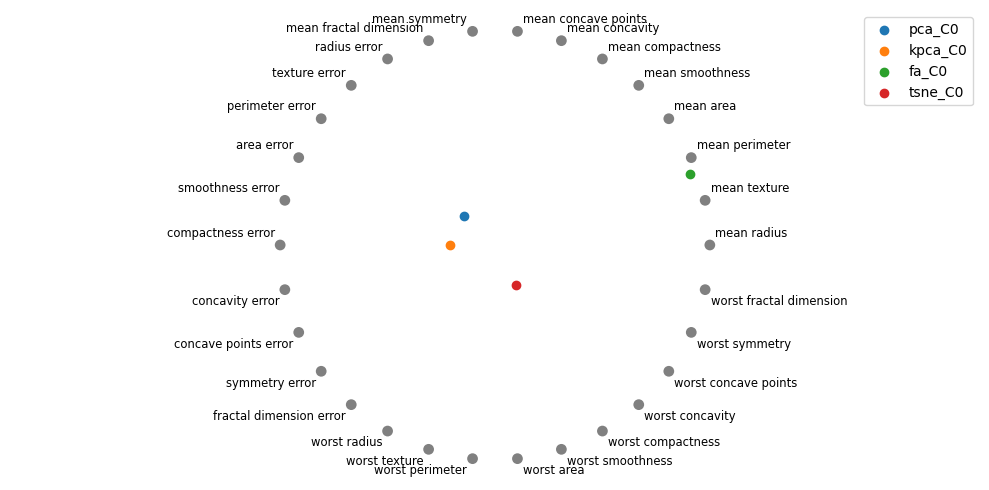

In [14]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

pd.plotting.radviz(
    I.assign(y=I.index)[[True if i.endswith('C0') else False for i in I.index]] \
        .drop(columns=['__mean radius']), 
    'y', 
    color=sns.color_palette('tab10'), 
    ax=ax
)
ax.axis('off')

fig.tight_layout()

Let me know if you think there's any signal with visualizing the coefficients of the features on the second component. It seems tSNE is moving towards the "error" features.

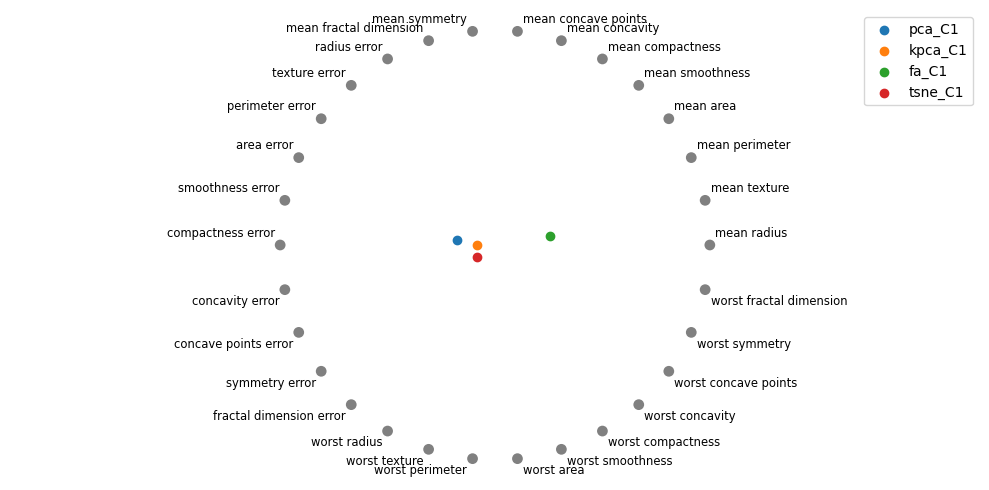

In [15]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

pd.plotting.radviz(
    I.assign(y=I.index)[[True if i.endswith('C1') else False for i in I.index]] \
        .drop(columns=['__mean radius']), 
    'y', 
    color=sns.color_palette('tab10'), 
    ax=ax
)
ax.axis('off')

fig.tight_layout()

## Polar plots

What about polar plots? 

In [16]:
from matplotlib.text import Text

def plot_polar(X, markersize=3, linewidth=1, alpha=1.0):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 7))

    d = X.shape[1]
    s = 360 / (d - 1)
    m = s * d + 1

    degrees = np.arange(s, m, s)
    radians = np.deg2rad(degrees)
    
    colors = sns.color_palette('tab10')
    for (name, r), color in zip(X.iterrows(), colors):
        ax.plot(
            radians, 
            r, 
            marker='o', 
            markersize=markersize, 
            linewidth=linewidth, 
            color=color,
            alpha=alpha,
            label=name
        )

    ax.set_yticklabels([])
    ax.set_ylim(0, 150)
    ax.spines['polar'].set_alpha(0.1)

    x2l = {k: v for k, v in zip([0] + list(radians), X.columns[:X.shape[1]-1])}
    x_ticks = [x for x, _ in x2l.items()]
    x_labels = [Text(x, 0, label) for x, label in x2l.items()]

    ax.xaxis.set_ticks(x_ticks)
    ax.xaxis.set_ticklabels(x_labels)
    ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

    for gl in ax.xaxis.get_gridlines():
        gl.set_alpha(0.1)

    for gl in ax.yaxis.get_gridlines():
        gl.set_alpha(0.1)

    fig.tight_layout()

This polar plot is of the coefficients of the raw features on the projection into the first component. 

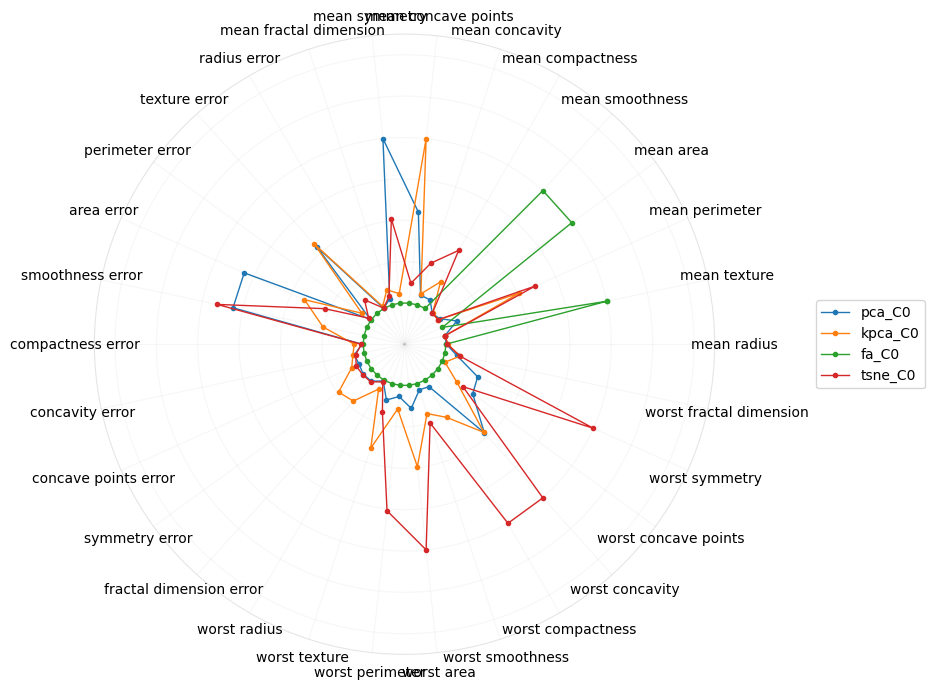

In [17]:
plot_polar(I[[True if i.endswith('C0') else False for i in I.index]])

This polar plot is of the coefficients of the raw features on the projection into the second component. 

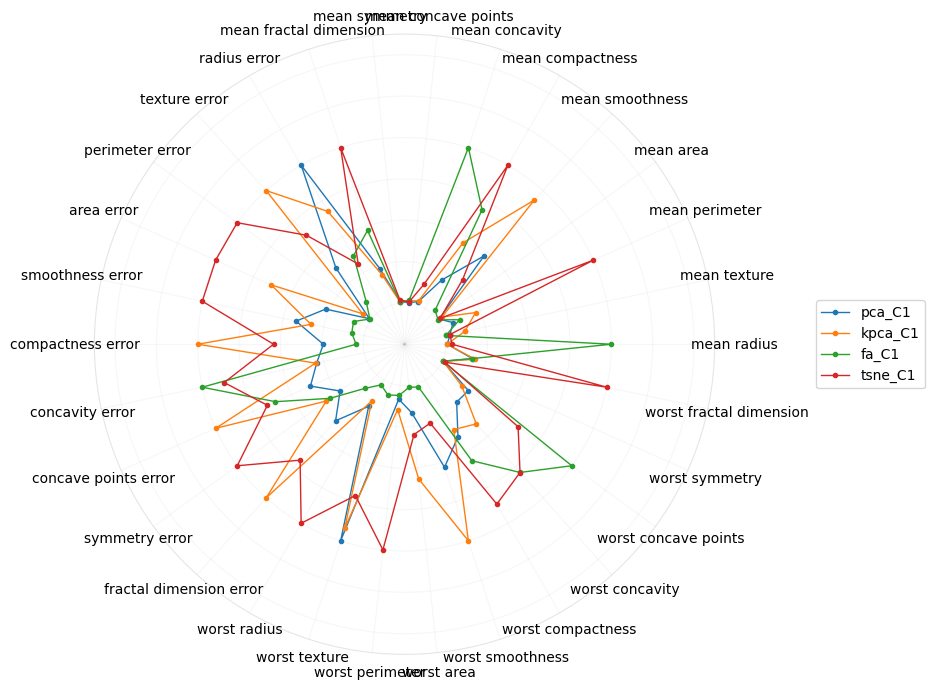

In [18]:
plot_polar(I[[True if i.endswith('C1') else False for i in I.index]])

What if we just look at PCA?

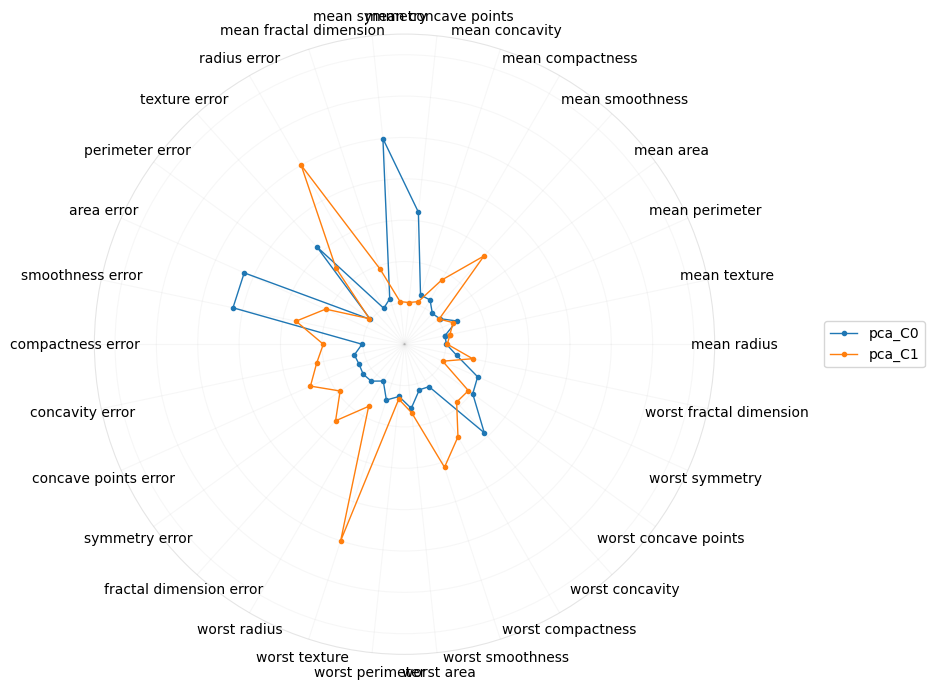

In [19]:
plot_polar(I[[True if i.startswith('pca') else False for i in I.index]])

What if we just looked at kernel PCA?

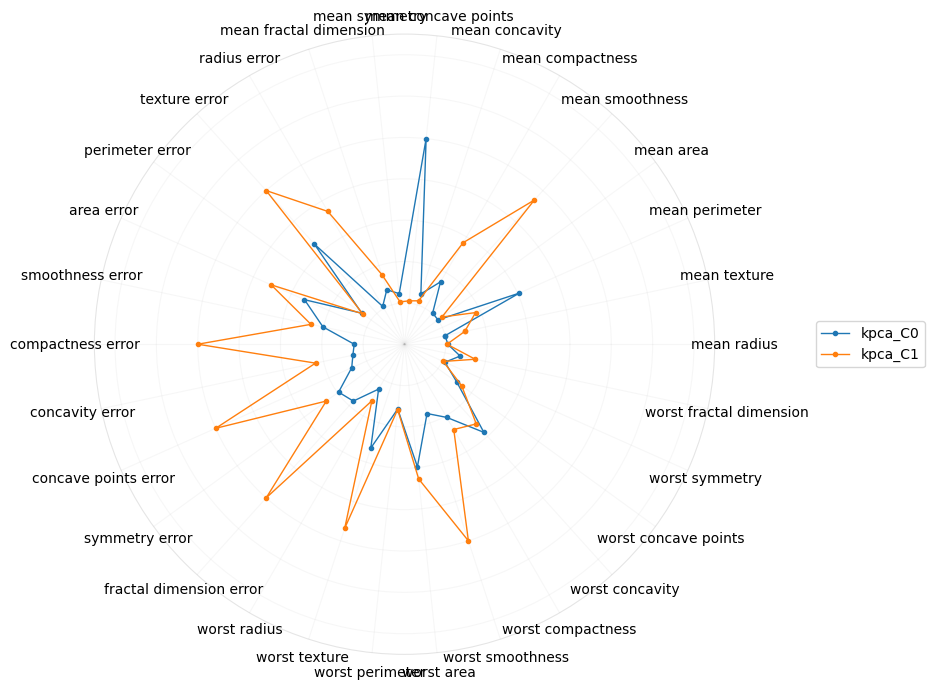

In [20]:
plot_polar(I[[True if i.startswith('kpca') else False for i in I.index]])

Or just factor analysis?

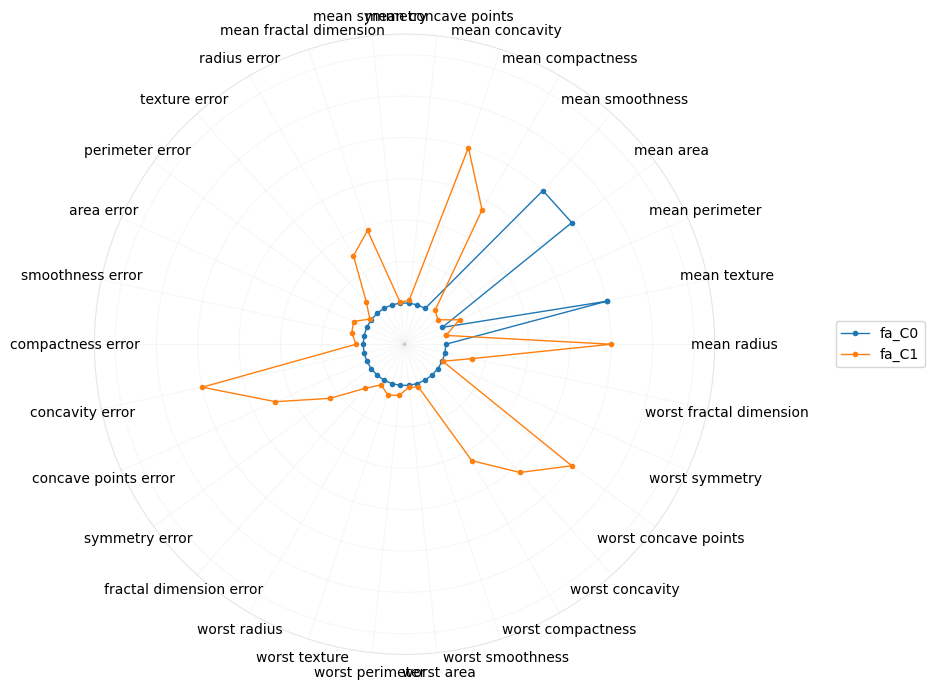

In [21]:
plot_polar(I[[True if i.startswith('fa') else False for i in I.index]])

And lastly, for tSNE. 

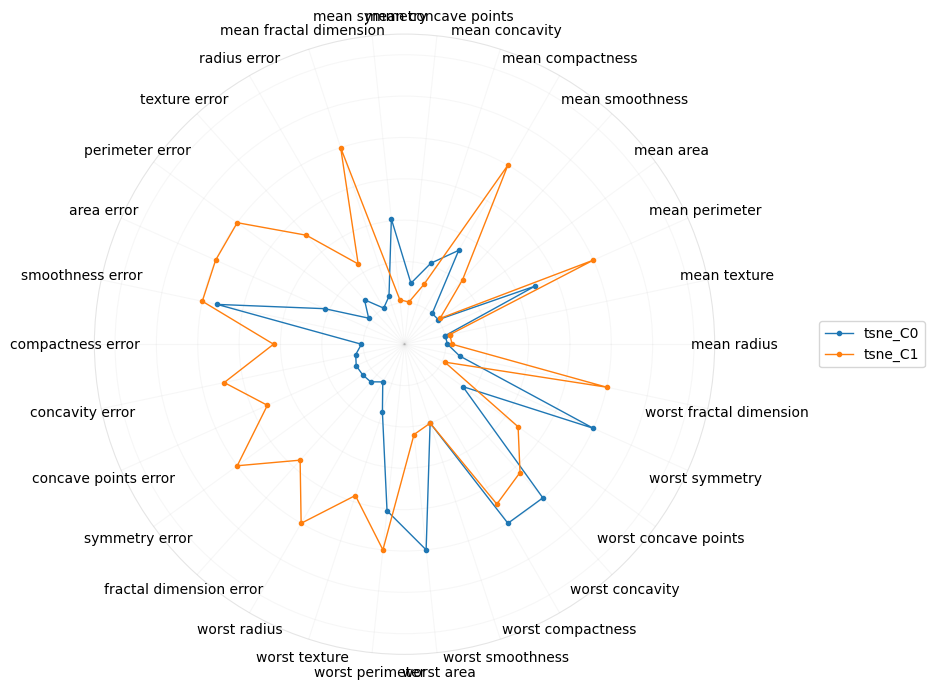

In [22]:
plot_polar(I[[True if i.startswith('tsne') else False for i in I.index]])

## Summary

Dimension reduction may be necessary to avoid certain problems associated with high-dimensionality. However, when reducing the dimensions, we are not simply doing "feature selection" (eg taking 30 features, in this case, and selecting only 2 from the 30). The dimension reduction techniques here are actually projecting the old/original dimensions into new ones, and those new (but fewer) dimensions have (higher-order) meaning, although it may not be easy to interpret exactly and precisely what those meanings may be. 